# Download data from
["The Comprehensive Cars (CompCars) dataset"](http://mmlab.ie.cuhk.edu.hk/datasets/comp_cars/index.html)

In [1]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eyy55ZOwRUfFm0EZUOVLZAOIayEvc-b9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eyy55ZOwRUfFm0EZUOVLZAOIayEvc-b9" -O combined.zip && rm -rf /tmp/cookies.txt


In [2]:
#!unzip -P d89551fd190e38 combined.zip

In [3]:
#!wget https://raw.githubusercontent.com/facebookresearch/maskrcnn-benchmark/master/configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml
# !wget https://github.com/facebookresearch/maskrcnn-benchmark/raw/master/demo/predictor.py

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2
import glob
import os
import random
import time
import datetime
import h5py

In [5]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

In [6]:
from maskrcnn_benchmark.config import cfg
from predictor2 import COCODemo

In [7]:
config_file = "e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])
cfg.merge_from_list(["TEST.IMS_PER_BATCH", 16])
cfg.merge_from_list(["DATALOADER.NUM_WORKERS", 8])

In [8]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [9]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [10]:
# https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def resize2SquareKeepingAspectRation(img, size, interpolation):
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h
    else:     dif = w
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    if c is None:
        mask = np.ones((dif, dif), dtype=img.dtype)*255
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.ones((dif, dif, c), dtype=img.dtype)*255
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
    return cv2.resize(mask, (size, size), interpolation)

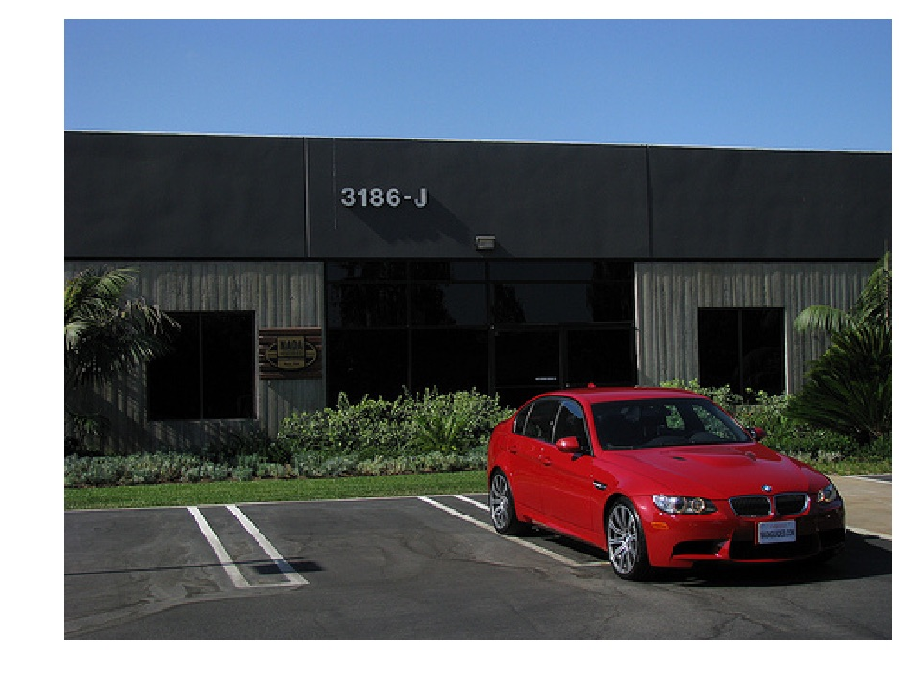

In [11]:
image = cv2.imread("car.jpg", cv2.IMREAD_COLOR)

imshow(image)

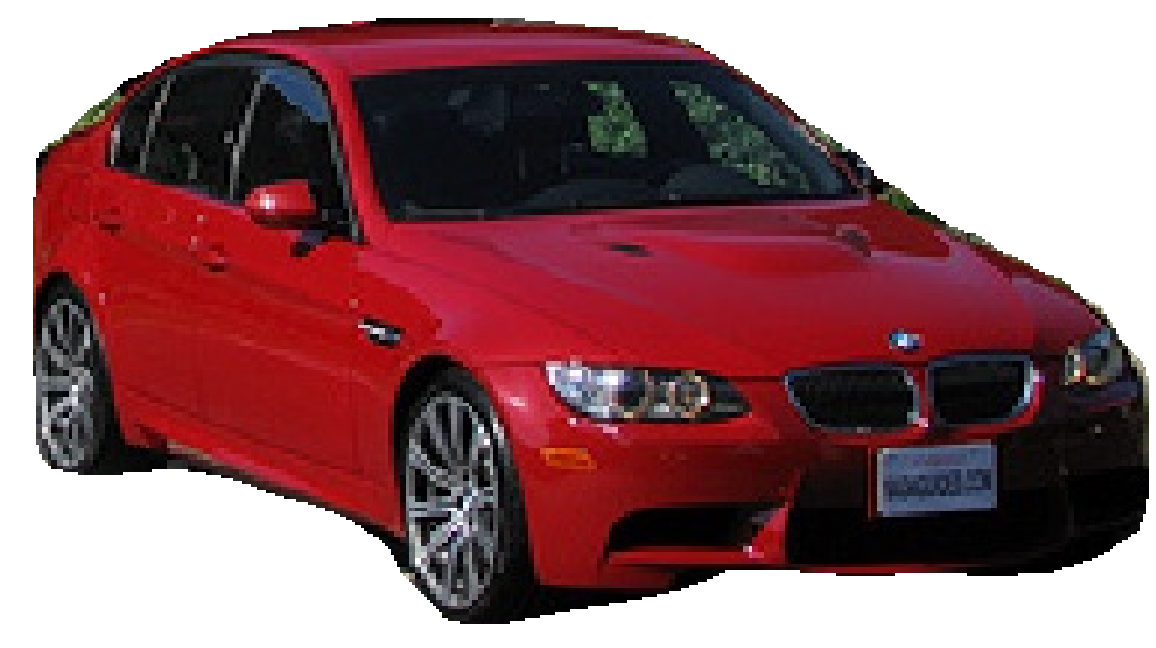

In [12]:
predictions,_ = coco_demo.run_on_opencv_image(image)
imshow(predictions)

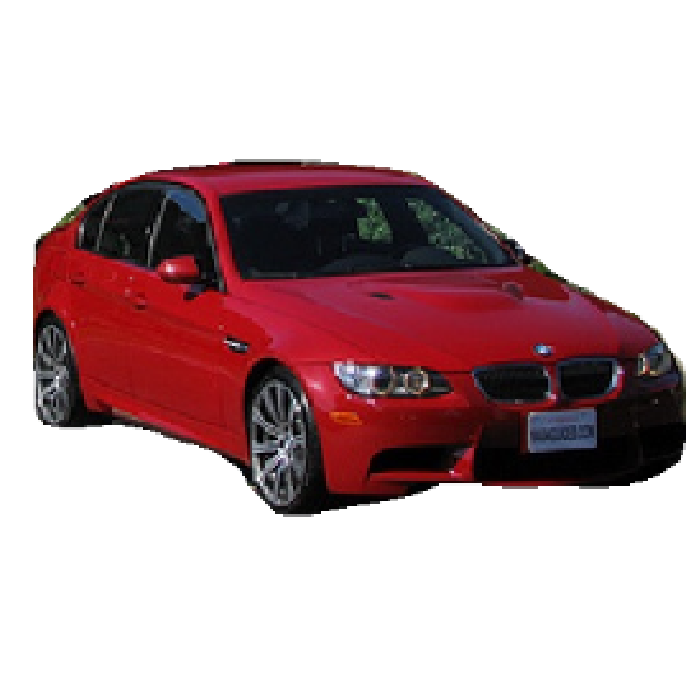

In [13]:
img = resize2SquareKeepingAspectRation(predictions, 256, cv2.INTER_AREA)
imshow(img)

In [14]:
path = os.getcwd()
print(path)

/home/guest/pytorch-car-pix2pix/data_preprocessing


In [15]:
file = glob.glob(path+"/data/image/**/*.jpg", recursive=True)

In [16]:
print("Total images",len(file))

Total images 136726


In [17]:
random.shuffle(file)
file[:10]

['/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/134/645/2009/8ad6d4fd2842cb.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/112/664/2011/3338b7a222c91c.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/118/979/2009/ec952b7e3ac80a.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/154/1051/2007/d3cf5aeef87bfe.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/97/872/2015/343b5313a3145b.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/159/1568/2012/e64f0037f67d4a.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/158/1281/2007/214f4830fb32eb.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/102/261/2014/71a6e9d1f69622.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/81/89/2011/b31375ddee3770.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/data/image/118/1004/2014/67e1a4f66a4cee.jpg']

In [18]:
file_sample = random.sample(file,k=50000)

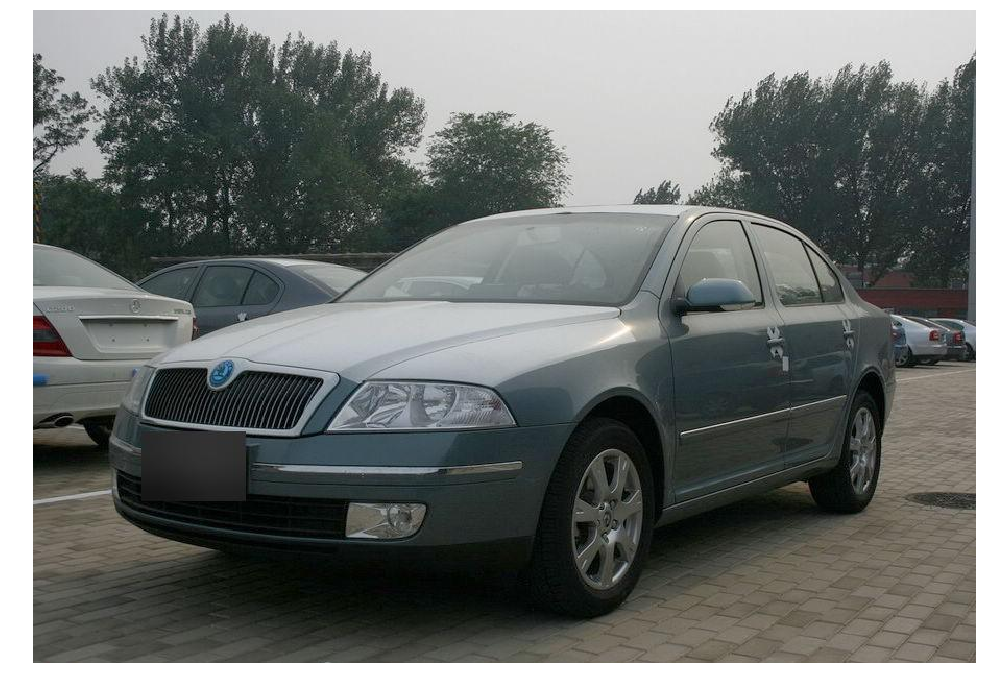

In [19]:
imshow(cv2.imread(file_sample[1000], cv2.IMREAD_COLOR))

In [20]:
filted_img = []
t = time.time()
for i in range(len(file_sample)):
    img = cv2.imread(file_sample[i], cv2.IMREAD_COLOR)
    img,is_car = coco_demo.run_on_opencv_image(img)
    if is_car and cb > 40000:
        filted_img.append(img)
    if i%100==0 and i!=0:
        fps = i/(time.time()-t)
        remain_time = (len(file_sample)/fps) - (i/fps)
        print('Load data: [{}/{}] {}FPS GET:'.format(i, 
                                                     len(file_sample),
                                                     round(fps,2),
                                                     len(filted_img)))
        print("Remain",datetime.timedelta(seconds = int(remain_time)))

ValueError: too many values to unpack (expected 2)

In [39]:
len(filted_img)

00010


In [18]:
save_path = "/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg/"

In [42]:
for i in range(len(filted_img)):
    name = format(i, '05d')
    cv2.imwrite(save_path+name+".jpg", filted_img[i])
    if i%100==0:
        print("Save image",i)

Save image 0
Save image 100
Save image 200
Save image 300
Save image 400
Save image 500
Save image 600
Save image 700
Save image 800
Save image 900
Save image 1000
Save image 1100
Save image 1200
Save image 1300
Save image 1400
Save image 1500
Save image 1600
Save image 1700
Save image 1800
Save image 1900
Save image 2000
Save image 2100
Save image 2200
Save image 2300
Save image 2400
Save image 2500
Save image 2600
Save image 2700
Save image 2800
Save image 2900
Save image 3000
Save image 3100
Save image 3200
Save image 3300
Save image 3400
Save image 3500
Save image 3600
Save image 3700
Save image 3800
Save image 3900
Save image 4000
Save image 4100
Save image 4200
Save image 4300
Save image 4400
Save image 4500
Save image 4600
Save image 4700
Save image 4800
Save image 4900
Save image 5000
Save image 5100
Save image 5200
Save image 5300
Save image 5400
Save image 5500
Save image 5600
Save image 5700
Save image 5800
Save image 5900
Save image 6000
Save image 6100
Save image 6200
Save

In [132]:
ffile = glob.glob(save_path2+"/*.jpg")

In [133]:
len(ffile)

22772

In [134]:
ffile[:10]

['/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/22698.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/03510.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/24923.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/21799.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/05525.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/00924.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/10746.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/17955.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/14121.jpg',
 '/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/01538.jpg']

In [135]:
testimg = cv2.imread(ffile[4])
#testimg = resize2SquareKeepingAspectRation(testimg, 256, cv2.INTER_AREA)

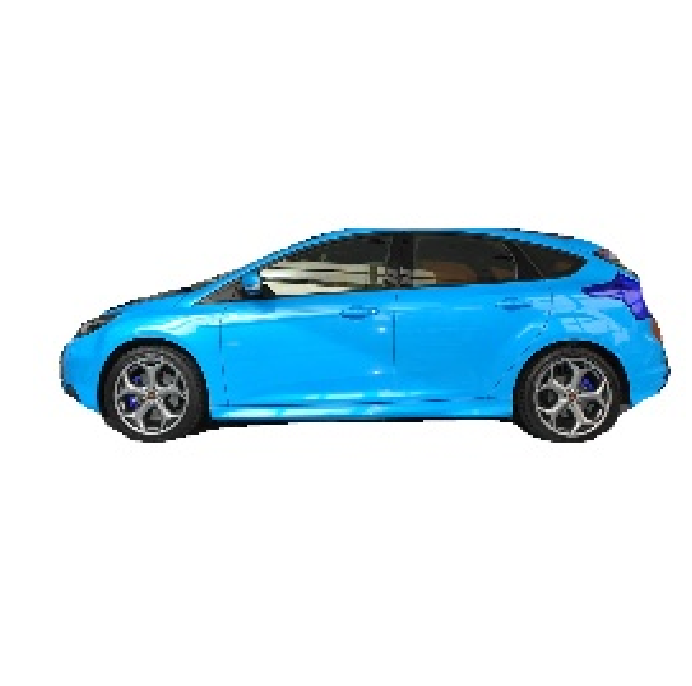

In [136]:
imshow(testimg)

In [137]:
new = cv2.cvtColor(testimg, cv2.COLOR_BGR2GRAY)
new = new.flatten()
new = [1 if i==255 else 0 for i in new ]
#a = 0 if new[0]==255 else 1

In [138]:
np.array(new).sum() #all white 50135040

47316

In [ ]:
for i in range(len(ffile)):
    img = cv2.imread(ffile[i])
    new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    new = new.flatten()
    new = [1 if i==255 else 0 for i in new ]
    if np.array(new).sum()>60000:
        os.remove(ffile[i])
        #print(np.array(new).sum())
        print("Remove image",i)
    

In [108]:
img = cv2.imread(ffile[0])
print(img.shape)
img = resize2SquareKeepingAspectRation(img, 256, cv2.INTER_AREA)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
edges = cv2.Canny(img, 200, 256)
newEdges = cv2.bitwise_not(edges)
newEdges = cv2.cvtColor(newEdges, cv2.COLOR_GRAY2BGR)

img = cv2.hconcat((img, newEdges))

(256, 256, 3)


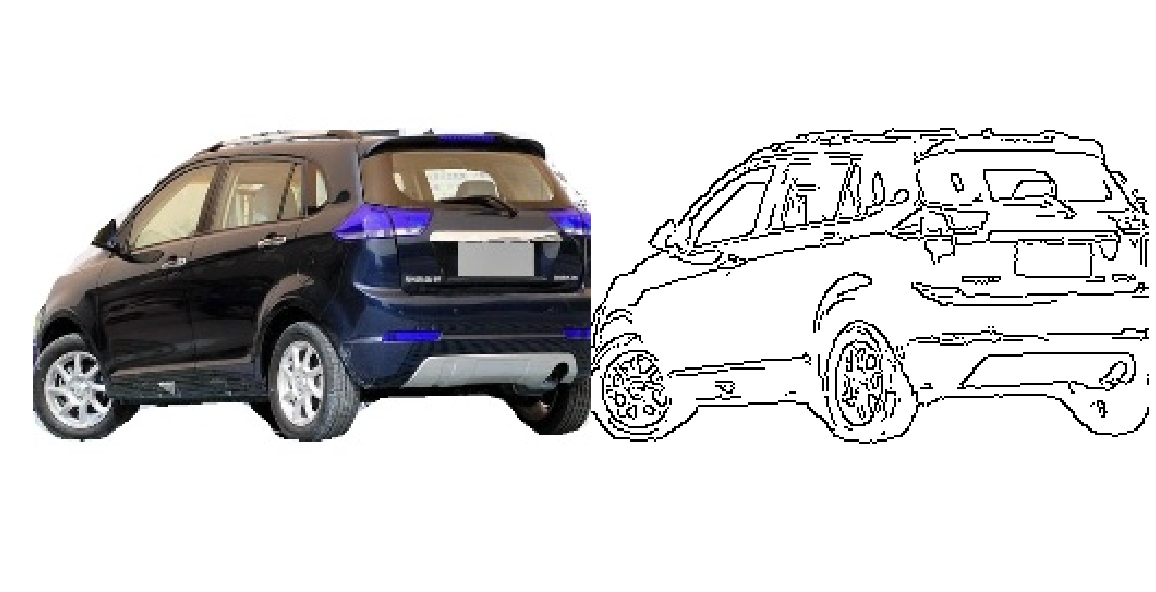

In [109]:
imshow(img)

In [112]:
def creatH5(data,sep,imgSize):
    
    imageName = data
    #label = np.array([data[i][1] for i in range(len(t))])
    #print(len(label[0]))
    leng = len(imageName)
    ALL = False
    if 'all' in format(sep):
        print("ALL")
        ALL = True
        sep = leng
    package = int(leng/sep)
    print("Total ",package,"pkgs")
    for i in range(package):
        partimageName = 0
        partlabel = 0    
        if ALL:
            partimageName = imageName
            #partlabel = label
        else:
            if i == (package-1):
                partimageName = imageName[sep*(i+1):]
                partlabel = label[sep*(i+1):]
            else:
                partimageName = imageName[sep*i:sep*(i+1)]
                partlabel = label[sep*i:sep*(i+1)]
        print("Image",len(partimageName))
        #print("Label",len(partlabel))
        filename = "RE256_all_data_"+format(sep)+"v"+format(i+1)
        data2h5(partimageName, filename, imgSize)

In [123]:
def data2h5(imgname, filename, imgSize):
    
    lengthof = len(imgname)
    ff = h5py.File(filename+".h5", mode='w')
    
    train_shape = (len(imgname), imgsize[0], imgsize[1]*2 , 3)
    ff.create_dataset("train_img", train_shape, np.uint8)
    #ff.create_dataset("train_labels", (len(leb),len(leb[0])), np.uint8)
    #print(len(leb[0]))
    #ff["train_labels"][...] = leb
    #print(len(leb))
    for k in range(lengthof):
        if k % 100 == 0 and k > 1:
            print ('Load data: {}/{}'.format(k, lengthof))

        #print(path+"/train/"+format(imgname[k])+'.png')
        img = cv2.imread(imgname[k])
        #img = imgname[k]
        #img = coco_demo.run_on_opencv_image(img)
        #print([img.shape[0],img.shape[1]])
        #img = cv2.resize(img,imgSize)
        img = resize2SquareKeepingAspectRation(img, imgSize[0], cv2.INTER_AREA)
        edges = cv2.Canny(img, 200, 256)
        newEdges = cv2.bitwise_not(edges)
        newEdges = cv2.cvtColor(newEdges, cv2.COLOR_GRAY2BGR)
        img = cv2.hconcat((img, newEdges))
        #print(img.shape)
        #img = cv2.resize(img, imgSize, fx=FX,fy=FX,interpolation=cv2.INTER_CUBIC)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
        #ff["train_img"][k, ...] = img
        ff["train_img"][k, ...] = np.expand_dims(img, axis=0)
        #ff["train_labels"][k] = leb[k] 
    ff.close()

In [124]:
imgsize = (256,256)
creatH5(ffile,'all',imgsize)

ALL
Total  1 pkgs
Image 21954
Load data: 100/21954
Load data: 200/21954
Load data: 300/21954
Load data: 400/21954
Load data: 500/21954
Load data: 600/21954
Load data: 700/21954
Load data: 800/21954
Load data: 900/21954
Load data: 1000/21954
Load data: 1100/21954
Load data: 1200/21954
Load data: 1300/21954
Load data: 1400/21954
Load data: 1500/21954
Load data: 1600/21954
Load data: 1700/21954
Load data: 1800/21954
Load data: 1900/21954
Load data: 2000/21954
Load data: 2100/21954
Load data: 2200/21954
Load data: 2300/21954
Load data: 2400/21954
Load data: 2500/21954
Load data: 2600/21954
Load data: 2700/21954
Load data: 2800/21954
Load data: 2900/21954
Load data: 3000/21954
Load data: 3100/21954
Load data: 3200/21954
Load data: 3300/21954
Load data: 3400/21954
Load data: 3500/21954
Load data: 3600/21954
Load data: 3700/21954
Load data: 3800/21954
Load data: 3900/21954
Load data: 4000/21954
Load data: 4100/21954
Load data: 4200/21954
Load data: 4300/21954
Load data: 4400/21954
Load data: 

In [125]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [126]:
Ffile = h5py.File("RE256_all_data_21954v1.h5", mode='r')

In [127]:
tran = np.einsum('klij->kjli', Ffile['train_img'][500:564,:,:])
print(tran.shape)
grid = torch.from_numpy(tran)
print(grid.shape)

(64, 3, 256, 512)
torch.Size([64, 3, 256, 512])


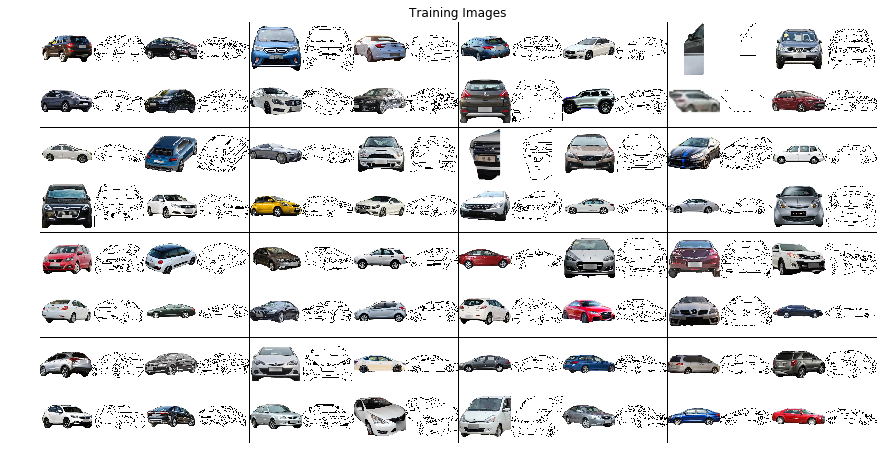

In [128]:
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(grid, padding=2),(1,2,0)))

In [129]:
len(Ffile['train_img'])

21954

In [130]:
save_path2 = "/home/guest/pytorch-car-pix2pix/data_preprocessing/fimg2/"

In [131]:
for i in range(len(Ffile['train_img'])):
    name = format(i, '05d')
    ii = Ffile['train_img'][i]
    ii = ii[0:256, 0:256]
    cv2.imwrite(save_path2+name+".jpg", ii)
    if i%100==0:
        print("Load image",i)

Load image 0
Load image 100
Load image 200
Load image 300
Load image 400
Load image 500
Load image 600
Load image 700
Load image 800
Load image 900
Load image 1000
Load image 1100
Load image 1200
Load image 1300
Load image 1400
Load image 1500
Load image 1600
Load image 1700
Load image 1800
Load image 1900
Load image 2000
Load image 2100
Load image 2200
Load image 2300
Load image 2400
Load image 2500
Load image 2600
Load image 2700
Load image 2800
Load image 2900
Load image 3000
Load image 3100
Load image 3200
Load image 3300
Load image 3400
Load image 3500
Load image 3600
Load image 3700
Load image 3800
Load image 3900


KeyboardInterrupt: 